# This notebook processes artificial BCS data for result comparison 

In [1]:
# import necessary modules
from dataclasses import dataclass
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from typing import TypedDict
import cv2
from skimage.filters import threshold_yen
from skimage.measure import label, regionprops
from tqdm import tqdm
import pandas as pd

# Define a typed dictionary to store metadata (artificial image sources) for images
@dataclass
class ImageMetadata:
    compression_batch: int
    blocked_batch_name: str
    source_site: str
    s_number: str
    position: str
    root_path: str
    corner_data: np.ndarray
    suffix: str = "png"

    def get_path(self) -> str:
        return os.path.join(
            f'bcs_results{self.compression_batch:03d}',
            "result_centered",
            self.blocked_batch_name,
            self.source_site,
            self.s_number,
            self.position
        )
        


# Define 4 corners of the CENER image, the corners are in (x, y) format
CENER_CORNERS = np.array([
    [348, 77],
    [1135, 77],
    [305, 873],
    [1172, 879]
])

CESA_CORNERS = np.array([
    [72, 61],
    [1962, 59],
    [68, 1951],
    [1964, 1950]
])

STJA_CORNERS = np.array([
    [0, 0],
    [255, 0],
    [0, 255],
    [255, 255]
])

COMPRESSION_BATCH = 1
BLOCKED_BATCH_NAME = "blocked_0p2"
SOURCE_SITE = "cener"
S_NUMBER = "S25"
POSITION = "pos1"
FILE_SUFFIX = "png"
ROOT_PATH = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\ArtificialImages\New_Files"

img_metadata = ImageMetadata(
    compression_batch=COMPRESSION_BATCH,
    blocked_batch_name=BLOCKED_BATCH_NAME,
    source_site=SOURCE_SITE,
    s_number=S_NUMBER,
    position=POSITION,
    root_path=ROOT_PATH,
    suffix=FILE_SUFFIX,
    corner_data=CENER_CORNERS
)
#\bcs_results001\result_centered\blocked_0p0\cener\s25\pos1

csv_save_folder = os.path.join(
    r"C:\Users\qzheng\Documents",
    img_metadata.get_path()
)

0it [00:00, ?it/s]

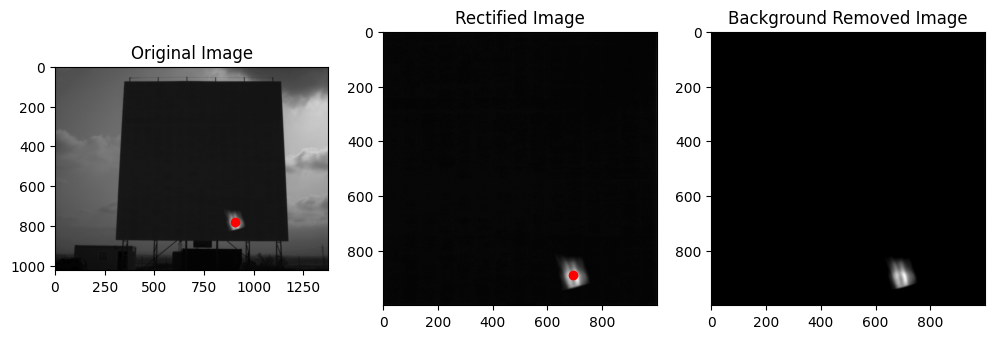

80it [00:06, 13.23it/s]


In [2]:
visualize_image_index = 0

# crop and rectify the image based on the 4 corners
def crop_and_rectify(img: np.ndarray, corners: np.ndarray) -> tuple[np.ndarray, np.ndarray]:

    """Crops and rectifies the image based on the provided corner points, returns the rectified image and the transformation matrix.
    
    Args:
        img (np.ndarray): The input image to be cropped and rectified.
        corners (np.ndarray): A 4x2 array containing the (x, y) coordinates of the corners in the image.
        
    Returns:
        rectified_img (np.ndarray): The cropped and rectified image.
        M (np.ndarray): The perspective transformation matrix used for rectification.
    """


    # assume that the width and height are 1000 pixels each for simplicity, may need to be adjusted in the future
    witdth, height = 1000, 1000

    src_points = corners.astype(np.float32)
    dst_points = np.array([
        [0, 0],
        [witdth, 0],
        [0, height],
        [witdth, height]
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_points, dst_points)
    rectified_img = cv2.warpPerspective(img, M, (witdth, height))
    return rectified_img, M


def background_removal(img: np.ndarray, background_offset: float = 1.2) -> np.ndarray:
    """Removes backbround from the image based on the histogram peak. The assumption is that the background has the most frequentest pixel value. 
    The threshold is selected as the peak value multiplied by a background offset. Default background offset is 1.2
    
    Args:
        img (np.ndarray): The input image from which the background needs to be removed.
        background_offset (float): A multiplier to adjust the background threshold. Default is 1.2.
        
    Returns:
        img_bg_removed (np.ndarray): The image with the background removed."""
    hist, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    peak_ids = np.argmax(hist)
    background_level = bin_edges[peak_ids] * background_offset
    img_bg_removed = np.clip(img - background_level, 0, 255).astype(np.uint8)
    return img_bg_removed

def find_theshold_with_energy(img_input, energy_level):
    """Finds the threshold value for image centroid calculation based on the specified energy level."""
    sorted_data = np.sort(img_input.flatten())[::-1]
    cumulative_sum = np.cumsum(sorted_data)
    total_sum = cumulative_sum[-1]
    threshold_index = np.searchsorted(cumulative_sum, total_sum * energy_level / 100.0)
    threshold_value = sorted_data[threshold_index]
    return threshold_value

def find_centroid_by_energy(img_input, energy_level):
    threshold_value = find_theshold_with_energy(img_input, energy_level)
    img_threshold_bool = img_input >= threshold_value
    img_threshold = img_input * img_threshold_bool
    regionprops_list = regionprops(label(img_threshold > 0), intensity_image=img_threshold)
    sorted_regionprops = sorted(regionprops_list, key=lambda x: x.area, reverse=True)
    beam_center_pixel = sorted_regionprops[0].centroid
    return beam_center_pixel


   
# define a function to make the process more modular
def beam_center_calculation(image_metadata: ImageMetadata):
    image_folder_path = image_metadata.get_path()

    img_files = glob(os.path.join(image_metadata.root_path,image_folder_path, f"*.{image_metadata.suffix}"))

    # create en empty pandas dataframe to store the results, column names are "relative_path", "Centroid_X", "Centroid_Y"
    results_df = pd.DataFrame(columns=["relative_path", "Centroid_X", "Centroid_Y"])

    for i, img_file in tqdm(enumerate(img_files)):
        img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) # assert the image is in grayscale

        rectified_img, M = crop_and_rectify(img, image_metadata.corner_data)
        img_bg_removed = background_removal(rectified_img)
        center_location_rectified = find_centroid_by_energy(img_bg_removed, energy_level=90.0)
        # inverse M
        M_inv = np.linalg.inv(M)
        center_location_original_homogeneous = M_inv @ np.array([center_location_rectified[1], center_location_rectified[0], 1])
        # Normalize homogeneous coordinates by dividing by the third component
        center_location_original = center_location_original_homogeneous[:2] / center_location_original_homogeneous[2]

        if i == visualize_image_index:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(img, cmap='gray')
            # use red dot to mark the center location
            plt.plot(center_location_original[0], center_location_original[1], 'ro')
            plt.subplot(1, 3, 2)
            plt.title("Rectified Image")
            plt.imshow(rectified_img, cmap='gray')
            # use red dot to mark the center location
            plt.plot(center_location_rectified[1], center_location_rectified[0], 'ro')
            plt.subplot(1, 3, 3)
            plt.title("Background Removed Image")
            plt.imshow(img_bg_removed, cmap='gray')
            plt.show()

        # Append the results to the dataframe
        relative_path = os.path.relpath(img_file, image_metadata.root_path)
        relative_path = os.sep.join(relative_path.split(os.sep)[1:])
        results_df = pd.concat([results_df, pd.DataFrame({
            "relative_path": [relative_path],
            "Centroid_X": [center_location_original[0]],
            "Centroid_Y": [center_location_original[1]]
        })], ignore_index=True)

    return results_df

results_df = beam_center_calculation(img_metadata)
# save the results to a csv file
if not os.path.exists(csv_save_folder):
    os.makedirs(csv_save_folder)
results_df.to_csv(os.path.join(csv_save_folder, "beam_centroid_results.csv"), index=False)

0it [00:00, ?it/s]

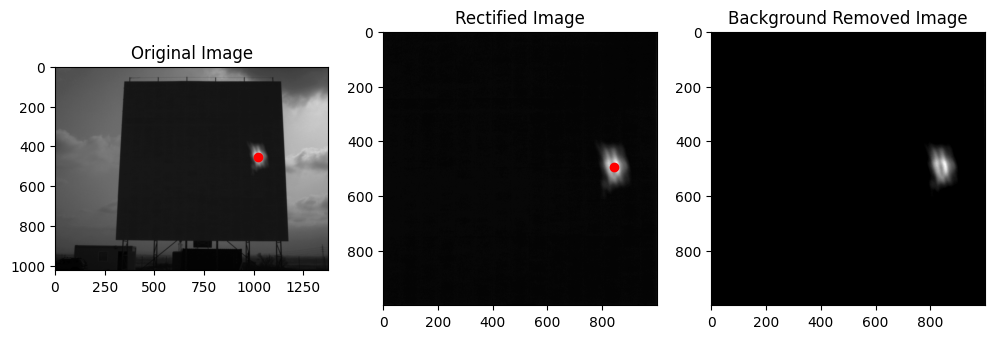

56it [00:04, 12.55it/s]
0it [00:00, ?it/s]

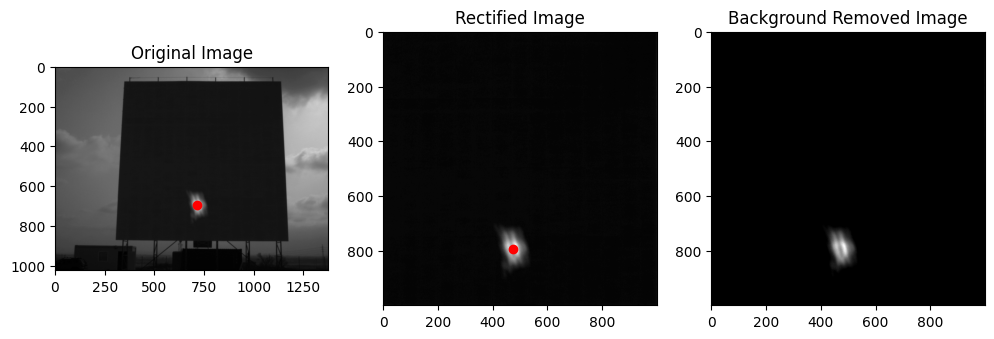

56it [00:23,  2.39it/s]
0it [00:00, ?it/s]

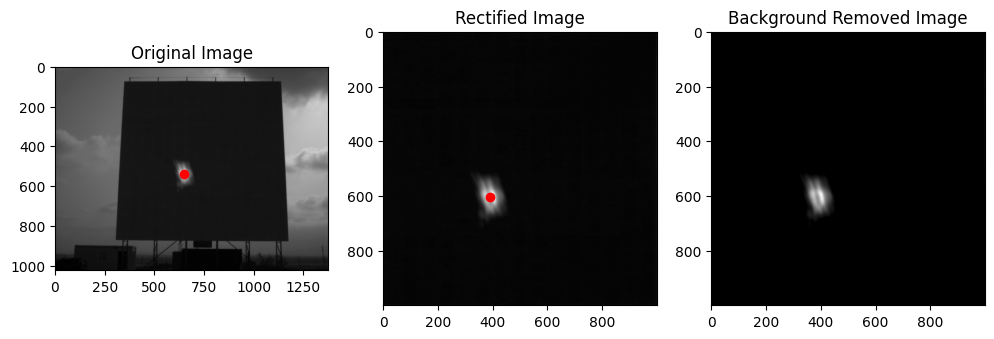

56it [00:27,  2.05it/s]
0it [00:00, ?it/s]

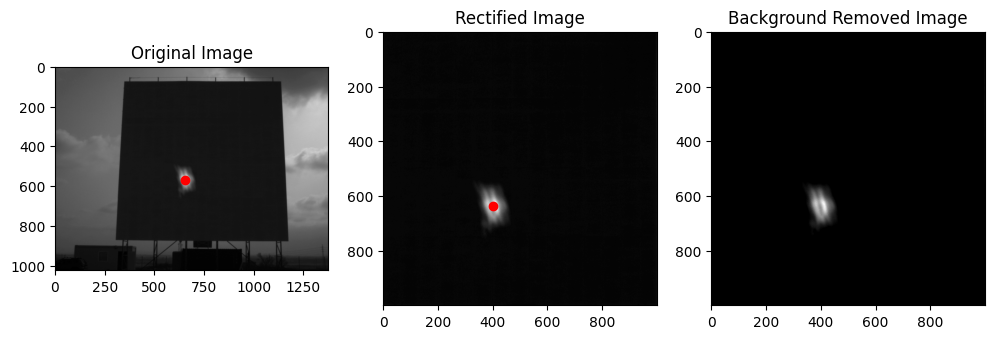

56it [00:29,  1.89it/s]
0it [00:00, ?it/s]

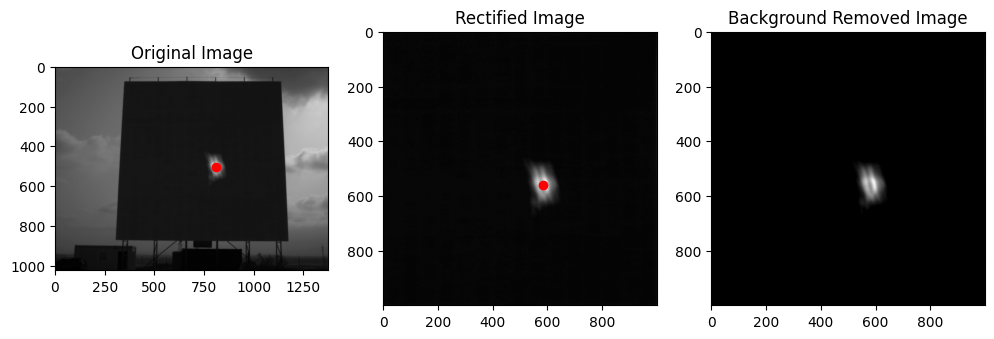

49it [00:23,  2.23it/s]

In [ ]:
# for loop to go over all data in the folders
compression_batch = 1
compression_data_folder = os.path.join(ROOT_PATH, f"bcs_results{compression_batch:03d}", "result_centered")

for blocked_batch_name in os.listdir(compression_data_folder):

    for source_site in os.listdir(os.path.join(compression_data_folder, blocked_batch_name)):

        for s_number in os.listdir(os.path.join(compression_data_folder, blocked_batch_name, source_site)):

            for position in os.listdir(os.path.join(compression_data_folder, blocked_batch_name, source_site, s_number)):

                if source_site.lower() == "cener":
                    corner_data = CENER_CORNERS
                elif source_site.lower() == "cesa":
                    corner_data = CESA_CORNERS
                elif source_site.lower() == "stja":
                    corner_data = STJA_CORNERS
                else:
                    raise ValueError(f"Unknown source site: {source_site}")

                img_metadata_loop = ImageMetadata(
                    compression_batch=compression_batch,
                    blocked_batch_name=blocked_batch_name,
                    source_site=source_site,
                    s_number=s_number,
                    position=position,
                    root_path=ROOT_PATH,
                    suffix=FILE_SUFFIX,
                    corner_data=corner_data
                )

                results_df_loop = beam_center_calculation(img_metadata_loop)
                # save the results to a csv file
                csv_save_folder_loop = os.path.join(
                    r"C:\Users\qzheng\Documents",
                    img_metadata_loop.get_path()
                )
                if not os.path.exists(csv_save_folder_loop):
                    os.makedirs(csv_save_folder_loop)
                results_df_loop.to_csv(os.path.join(csv_save_folder_loop, "beam_centroid_results.csv"), index=False)